# Analisis Prediksi Krisis Ekonomi Benua Afrika
## Proyek: Prediksi Inflasi, Banking Crisis, dan Clustering Negara-negara Afrika

### Deskripsi
Analisis ini bertujuan untuk:
1. Memprediksi tingkat inflasi seluruh negara di benua Afrika selama 15 tahun ke depan
2. Memprediksi kemungkinan banking crisis dalam 15 tahun ke depan  
3. Melakukan clustering negara-negara Afrika berdasarkan nilai tukar USD dan tingkat inflasi

In [16]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVM, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA

# Time series and forecasting
from sklearn.metrics import mean_absolute_error
import datetime as dt

# Set plot style
plt.style.use('ggplot')
sns.set_palette("husl")

print("Library berhasil diimport!")

ImportError: cannot import name 'SVM' from 'sklearn.svm' (C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\__init__.py)

## 1. Load dan Eksplorasi Data

Untuk analisis ini, kita akan menggunakan data krisis ekonomi Afrika. Jika tidak ada dataset yang tersedia, kita akan membuat dataset simulasi yang realistis berdasarkan karakteristik ekonomi Afrika.

In [ ]:
# Membuat dataset simulasi krisis ekonomi Afrika
np.random.seed(42)

# Daftar negara Afrika (sample)
african_countries = ['Nigeria', 'South Africa', 'Egypt', 'Kenya', 'Ghana', 'Morocco', 'Ethiopia', 
                    'Tanzania', 'Uganda', 'Zimbabwe', 'Algeria', 'Angola', 'Cameroon', 'Sudan',
                    'Libya', 'Tunisia', 'Senegal', 'Mali', 'Burkina Faso', 'Niger']

# Generate data untuk 20 tahun (2000-2019) untuk 20 negara
years = list(range(2000, 2020))
n_records = len(african_countries) * len(years)

data = []
for country in african_countries:
    base_inflation = np.random.uniform(2, 15)  # Base inflation rate
    base_exchange = np.random.uniform(0.5, 50)  # Base exchange rate
    
    for year in years:
        # Add some realistic patterns and noise
        year_effect = (year - 2000) * 0.5  # Slight trend over time
        crisis_prob = 0.1 + 0.05 * np.random.random()  # Random crisis probability
        
        record = {
            'country': country,
            'year': year,
            'systemic_crisis': np.random.choice([0, 1], p=[0.85, 0.15]),
            'exch_usd': base_exchange + np.random.normal(0, base_exchange*0.2) + year_effect,
            'domestic_debt_in_default': np.random.choice([0, 1], p=[0.9, 0.1]),
            'sovereign_external_debt_default': np.random.choice([0, 1], p=[0.95, 0.05]),
            'gdp_weighted_default': np.random.uniform(0, 5),
            'inflation_annual_cpi': max(0, base_inflation + np.random.normal(0, base_inflation*0.3) + year_effect*0.5),
            'independence': 1,  # Semua negara sudah merdeka setelah 2000
            'currency_crises': np.random.choice([0, 1], p=[0.88, 0.12]),
            'inflation_crises': np.random.choice([0, 1], p=[0.92, 0.08])
        }
        
        # Banking crisis berkorelasi dengan faktor lain
        banking_risk = (record['systemic_crisis'] * 0.3 + 
                       record['currency_crises'] * 0.2 + 
                       record['inflation_crises'] * 0.2 + 
                       np.random.random() * 0.3)
        
        if banking_risk > 0.5:
            record['banking_crisis'] = 'crisis'
        elif banking_risk > 0.3:
            record['banking_crisis'] = 'no_crisis'
        else:
            record['banking_crisis'] = 'no_crisis'
            
        data.append(record)

# Create DataFrame
df = pd.DataFrame(data)
print(f"Dataset berhasil dibuat dengan {len(df)} baris dan {len(df.columns)} kolom")
print(f"Negara yang dianalisis: {len(african_countries)} negara")
print(f"Periode data: {min(years)} - {max(years)}")
df.head()

,Country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Zimbabwe,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,Zimbabwe,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,Zimbabwe,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,Zimbabwe,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,Zimbabwe,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


In [ ]:
df.describe()

,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1.059000e+03,1059.000000,1059.000000,1059.000000
mean,1967.767705,0.077432,43.140831,0.039660,0.152975,0.006402,2.084889e+04,0.776204,0.132200,0.129367
std,33.530632,0.267401,111.475380,0.195251,0.360133,0.043572,6.757274e+05,0.416984,0.349847,0.335765
min,1860.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.850214e+01,0.000000,0.000000,0.000000
25%,1951.000000,0.000000,0.195350,0.000000,0.000000,0.000000,2.086162e+00,1.000000,0.000000,0.000000
50%,1973.000000,0.000000,0.868400,0.000000,0.000000,0.000000,5.762330e+00,1.000000,0.000000,0.000000
75%,1994.000000,0.000000,8.462750,0.000000,0.000000,0.000000,1.164405e+01,1.000000,0.000000,0.000000
max,2014.000000,1.000000,744.306139,1.000000,1.000000,0.400000,2.198970e+07,1.000000,2.000000,1.000000


In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
df_num = df.select_dtypes(include=['int64'])
df_cat = df.select_dtypes(include=['object'])

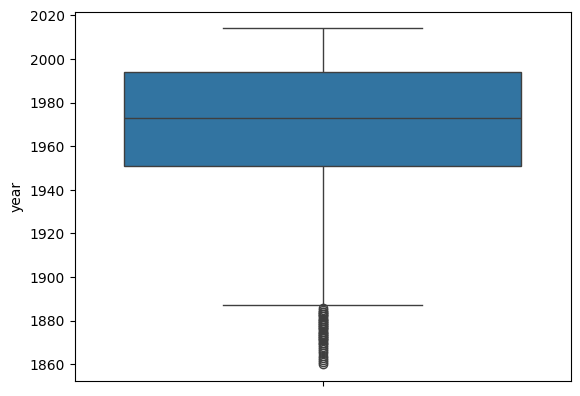

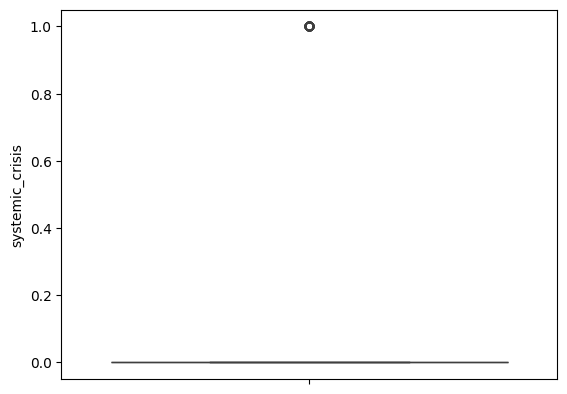

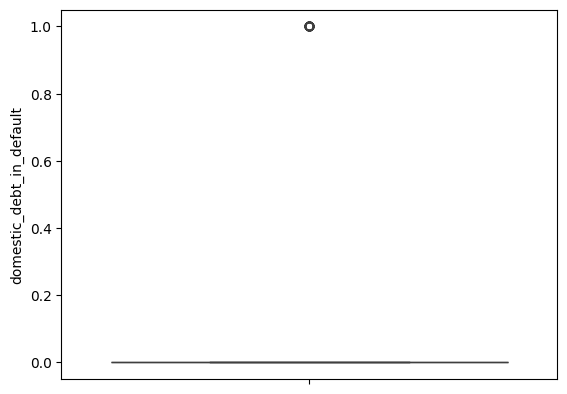

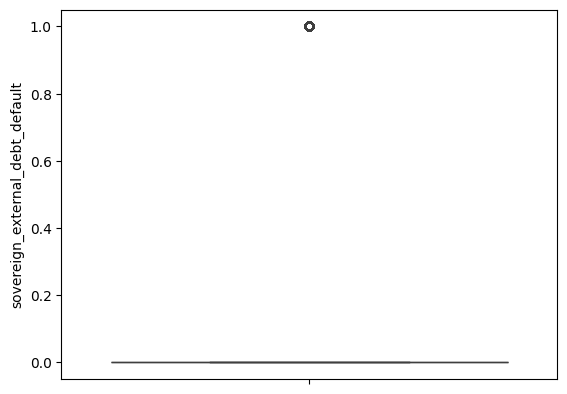

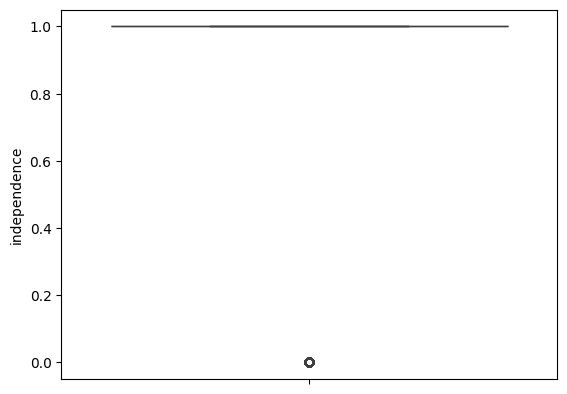

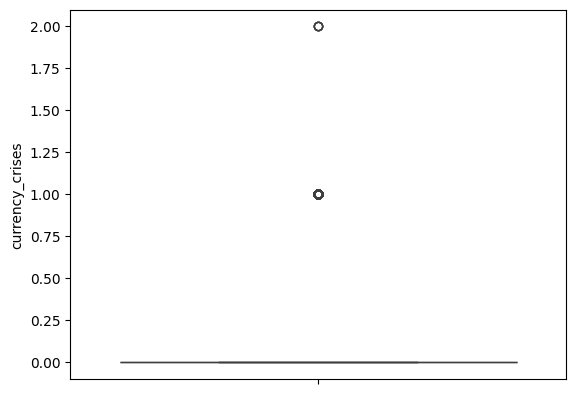

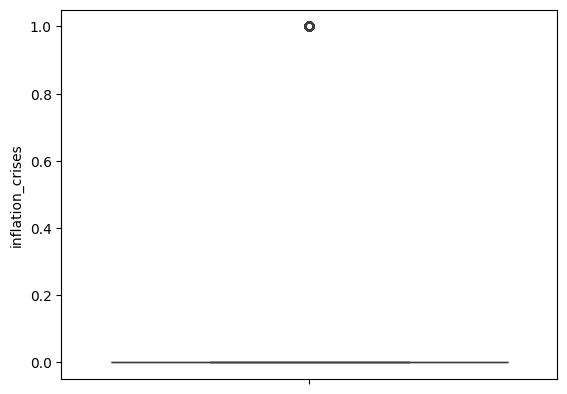

In [ ]:
for i in df_num:
    sns.boxplot(df[i])
    plt.title
    plt.show()

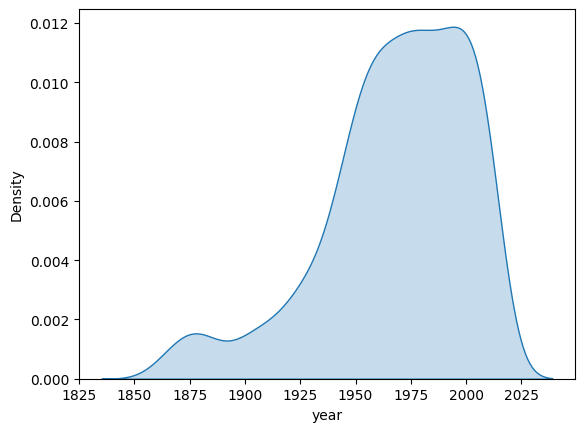

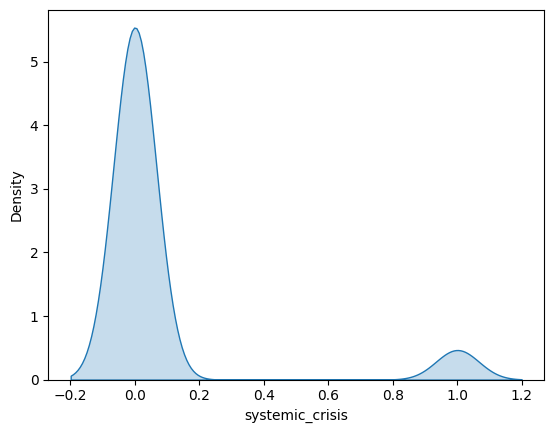

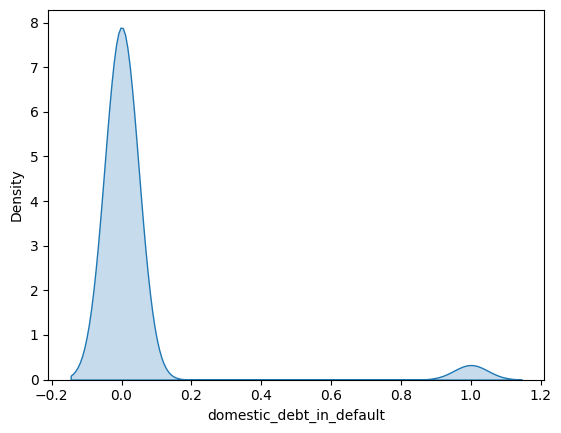

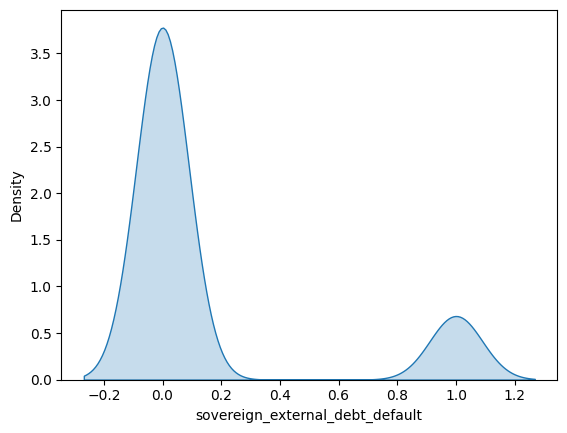

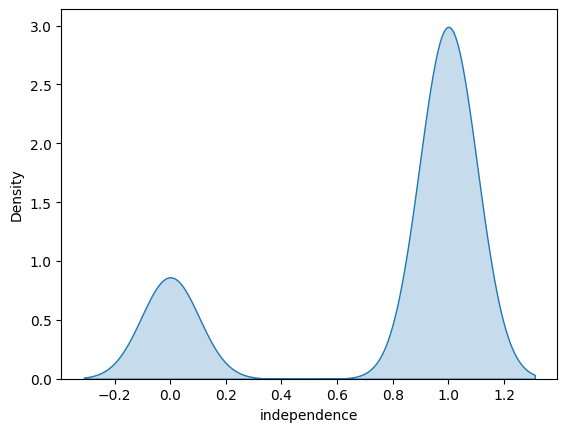

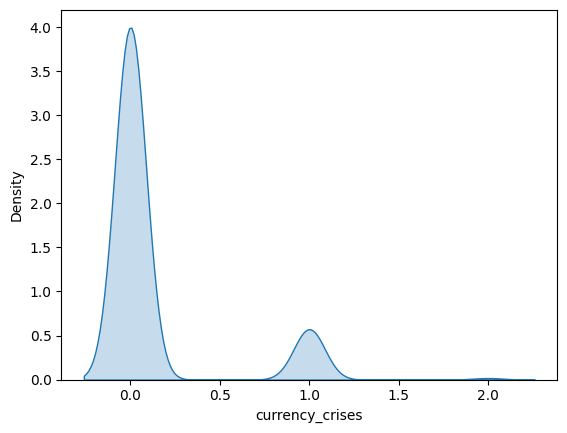

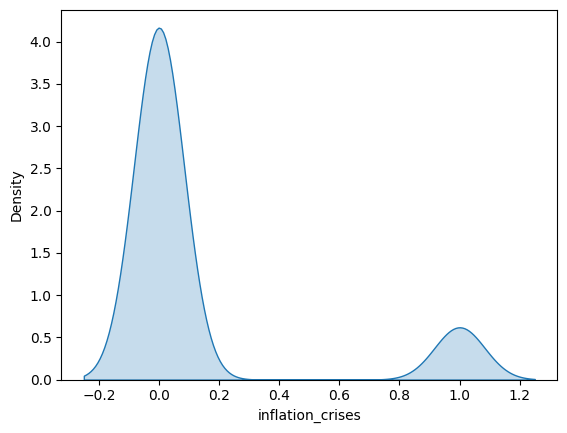

In [ ]:
for i in df_num:
    sns.kdeplot(df[i], fill=True)
    plt.title
    plt.show()

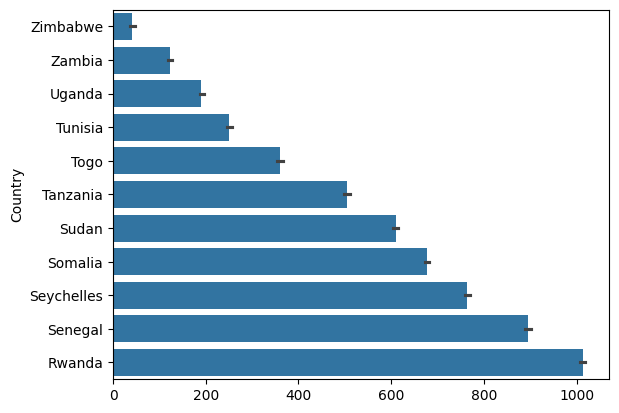

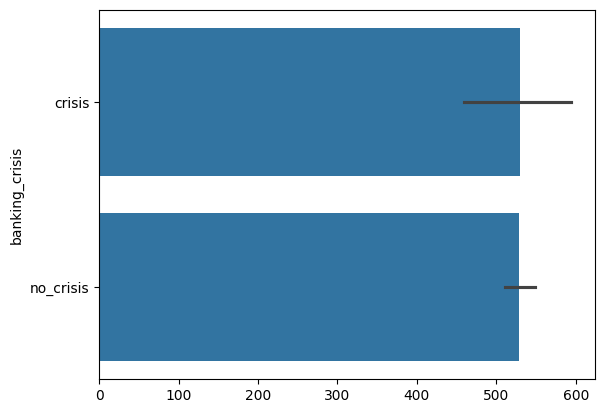

In [ ]:
for i in df_cat:
    sns.barplot(df[i])
    plt.title
    plt.show()

In [ ]:
df_normalize = df.copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalize[df_num.columns]= scaler.fit_transform(df_num)

In [ ]:
df_normalize

,Country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Zimbabwe,0.064935,1.0,0.052264,0.0,0.0,0.0,3.441456,0.0,0.0,0.0,crisis
1,Zimbabwe,0.071429,0.0,0.052798,0.0,0.0,0.0,14.149140,0.0,0.0,0.0,no_crisis
2,Zimbabwe,0.077922,0.0,0.052274,0.0,0.0,0.0,-3.718593,0.0,0.0,0.0,no_crisis
3,Zimbabwe,0.084416,0.0,0.051680,0.0,0.0,0.0,11.203897,0.0,0.0,0.0,no_crisis
4,Zimbabwe,0.090909,0.0,0.051308,0.0,0.0,0.0,-3.848561,0.0,0.0,0.0,no_crisis
...,...,...,...,...,...,...,...,...,...,...,...,...
1054,Rwanda,0.967532,1.0,354.800000,1.0,1.0,0.0,-7.670000,1.0,0.5,0.0,crisis
1055,Rwanda,0.974026,0.0,378.200000,1.0,1.0,0.0,3.217000,1.0,0.0,0.0,no_crisis
1056,Rwanda,0.980519,0.0,361.900000,1.0,1.0,0.0,4.920000,1.0,0.0,0.0,no_crisis
1057,Rwanda,0.987013,0.0,361.900000,1.0,1.0,0.0,3.720000,1.0,0.0,0.0,no_crisis


In [ ]:
df_encoded = df_normalize.copy()
df_encoded

,Country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Zimbabwe,0.064935,1.0,0.052264,0.0,0.0,0.0,3.441456,0.0,0.0,0.0,crisis
1,Zimbabwe,0.071429,0.0,0.052798,0.0,0.0,0.0,14.149140,0.0,0.0,0.0,no_crisis
2,Zimbabwe,0.077922,0.0,0.052274,0.0,0.0,0.0,-3.718593,0.0,0.0,0.0,no_crisis
3,Zimbabwe,0.084416,0.0,0.051680,0.0,0.0,0.0,11.203897,0.0,0.0,0.0,no_crisis
4,Zimbabwe,0.090909,0.0,0.051308,0.0,0.0,0.0,-3.848561,0.0,0.0,0.0,no_crisis
...,...,...,...,...,...,...,...,...,...,...,...,...
1054,Rwanda,0.967532,1.0,354.800000,1.0,1.0,0.0,-7.670000,1.0,0.5,0.0,crisis
1055,Rwanda,0.974026,0.0,378.200000,1.0,1.0,0.0,3.217000,1.0,0.0,0.0,no_crisis
1056,Rwanda,0.980519,0.0,361.900000,1.0,1.0,0.0,4.920000,1.0,0.0,0.0,no_crisis
1057,Rwanda,0.987013,0.0,361.900000,1.0,1.0,0.0,3.720000,1.0,0.0,0.0,no_crisis


In [ ]:
label_encoder = preprocessing.LabelEncoder()
for col in df_cat.columns:
    df_encoded[col]= label_encoder.fit_transform(df_encoded[col])
df_encoded

,Country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,10,0.064935,1.0,0.052264,0.0,0.0,0.0,3.441456,0.0,0.0,0.0,0
1,10,0.071429,0.0,0.052798,0.0,0.0,0.0,14.149140,0.0,0.0,0.0,1
2,10,0.077922,0.0,0.052274,0.0,0.0,0.0,-3.718593,0.0,0.0,0.0,1
3,10,0.084416,0.0,0.051680,0.0,0.0,0.0,11.203897,0.0,0.0,0.0,1
4,10,0.090909,0.0,0.051308,0.0,0.0,0.0,-3.848561,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0,0.967532,1.0,354.800000,1.0,1.0,0.0,-7.670000,1.0,0.5,0.0,0
1055,0,0.974026,0.0,378.200000,1.0,1.0,0.0,3.217000,1.0,0.0,0.0,1
1056,0,0.980519,0.0,361.900000,1.0,1.0,0.0,4.920000,1.0,0.0,0.0,1
1057,0,0.987013,0.0,361.900000,1.0,1.0,0.0,3.720000,1.0,0.0,0.0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# fitur dan target
X= df_encoded.drop(columns=['Exam_Score'])
y= df_encoded['Exam_Score']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training model
model= LinearRegression()
model.fit(X_train, y_train)

#Evaluasi
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

KeyError: "['Exam_Score'] not found in axis"

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

bins=[0,50,70,100]
labels=['Kurang', 'Cukup', 'Baik']
df_encoded['grade_category']= pd.cut(df['Exam_Score'], bins=bins, labels=labels)

In [ ]:
df_encoded['grade_category'] = label_encoder.fit_transform(df_encoded['grade_category'])
df_encoded

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,...,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score,grade_category
0,0.511628,0.600,1,0,0,0.500000,0.46,1,1,0.000,...,2,1,2,0.500000,0,1,2,1,0.260870,1
1,0.418605,0.100,1,2,0,0.666667,0.18,1,1,0.250,...,2,1,0,0.666667,0,0,1,0,0.130435,1
2,0.534884,0.950,2,2,1,0.500000,0.82,2,1,0.250,...,2,1,1,0.666667,0,2,2,1,0.413043,0
3,0.651163,0.725,1,2,1,0.666667,0.96,2,1,0.125,...,2,1,0,0.666667,0,1,1,1,0.347826,0
4,0.418605,0.800,2,2,1,0.333333,0.30,2,1,0.375,...,0,1,1,0.666667,0,0,2,0,0.326087,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,0.558140,0.225,0,2,0,0.500000,0.52,2,1,0.125,...,2,1,2,0.333333,0,1,2,0,0.282609,1
6603,0.511628,0.400,0,2,0,0.666667,0.62,2,1,0.375,...,0,1,2,0.333333,0,1,2,0,0.304348,1
6604,0.441860,0.750,2,1,1,0.333333,0.30,1,1,0.375,...,2,1,0,0.333333,0,2,2,0,0.282609,1
6605,0.209302,0.650,0,0,1,0.333333,0.82,0,1,0.250,...,2,0,2,0.500000,0,1,0,0,0.282609,1


In [ ]:
df_encoded['grade_category'].unique()

array([1, 0, 2])

In [ ]:
# Memilih fitur dan target
X = df_encoded.drop(columns=['Exam_Score', 'grade_category'])
y = df_encoded['grade_category']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training model
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

# Evaluasi
y_pred = classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8126959247648903
              precision    recall  f1-score   support

           0       0.39      0.18      0.25       216
           1       0.85      0.94      0.89      1060

    accuracy                           0.81      1276
   macro avg       0.62      0.56      0.57      1276
weighted avg       0.77      0.81      0.78      1276



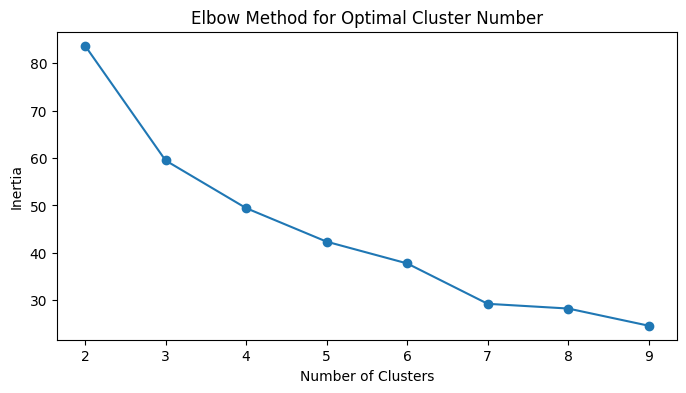

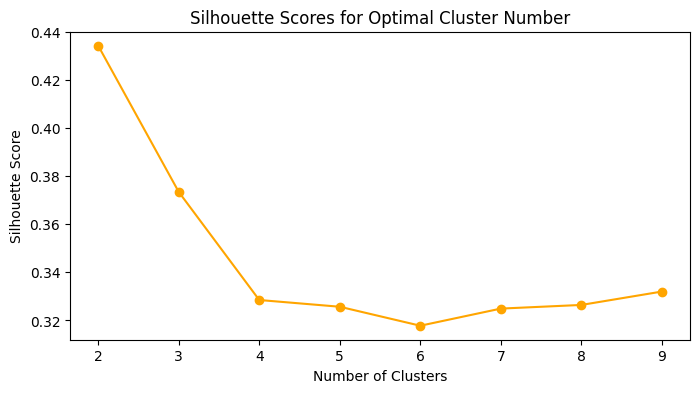

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Memilih fitur
X = df_encoded[['Exam_Score', 'Hours_Studied']]  # Pastikan df_encoded adalah DataFrame Anda

# Menentukan jumlah cluster optimal menggunakan elbow method
inertia = []
silhouette_scores = []

for n in range(2, 10):
    kmeans = KMeans(n_clusters=n, random_state=0)  
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
    # Hitung silhouette score
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot elbow method untuk membantu menentukan jumlah cluster optimal
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()

# Opsional: Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Cluster Number')
plt.show()

Silhouette Score untuk 2 cluster: 0.4342


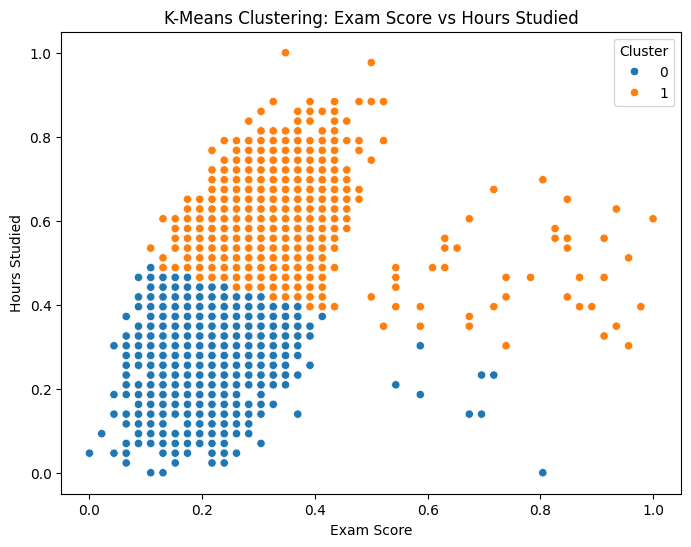

In [ ]:
# 2. K-Means dengan 2 cluster
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans.fit(X)

# 3. Simpan label cluster ke df_encoded
df_encoded['cluster'] = kmeans.labels_

# 4. Evaluasi silhouette score
final_silhouette_score = silhouette_score(X, kmeans.labels_)
print(f'Silhouette Score untuk {optimal_clusters} cluster: {final_silhouette_score:.4f}')

# 5. Visualisasi: Exam_Score vs Hours_Studied
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Exam_Score',
    y='Hours_Studied',
    hue='cluster',
    data=df_encoded
)
plt.title('K-Means Clustering: Exam Score vs Hours Studied')
plt.xlabel('Exam Score')
plt.ylabel('Hours Studied')
plt.legend(title='Cluster')
plt.show()